# Part I: Classification

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus

## 1) Load in the dataset
`https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [240]:
df = pd.read_csv("https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv")

In [241]:
df = df.drop(["Unnamed: 0"], axis = 1)

#### Check out class imbalance

In [242]:
print("Samples per class (No): {}".format(sum(df["default"] == "No")))
print("Samples per class (Yes): {}".format(sum(df["default"] == "Yes")))

Samples per class (No): 9667
Samples per class (Yes): 333


** Also class weight = balanced is used for all models since data is highly imbalanced. **

## 2) Convert `default` and `student` to categorical variables.

In [244]:
# Convert to binary
df["default"] = pd.Series(np.where(df["default"].values == 'Yes', 1, 0),
          df["default"].index)

In [245]:
# Convert to binary
df['student'] = pd.Series(np.where(df["student"].values == 'Yes', 1, 0),
          df["student"].index)

## 3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color of the outcome of `default` labeled red if yes and blue if no. 

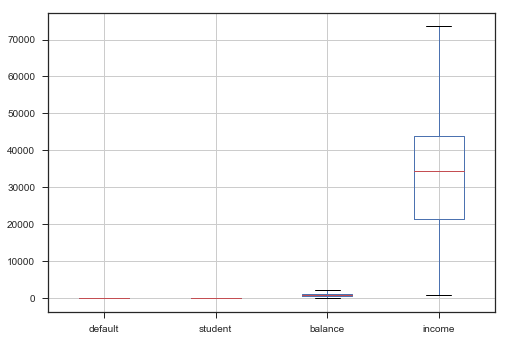

In [246]:
df.boxplot()
plt.show()

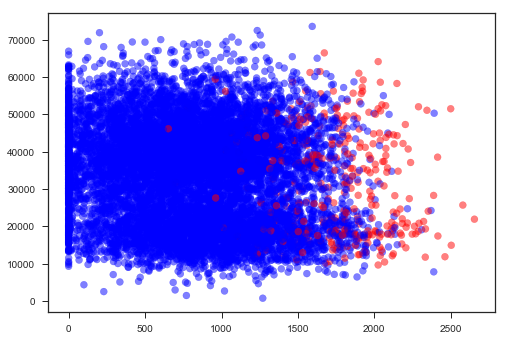

In [247]:
colors= df ["default"]
colors = colors.replace(1,"r").replace(0,"b")
plt.scatter(df['balance'],df['income'],c = colors, alpha=0.5)
plt.show()

## 4) 

Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley on the `balance` and `income` variables. 

Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

In [256]:
y = df.loc[:,"default"]
X = df.loc[:,["balance", "income"]]

In [249]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, random_state = 9598) #Splitting the data into Test and Train

In [250]:
lr = LogisticRegression(class_weight='balanced', penalty='l1').fit(X_train1,y_train1)
pred = lr.predict(X_test1)
print(roc_auc_score(y_test1, pred))

0.8706813191000853


#### Plot Decision Boundary

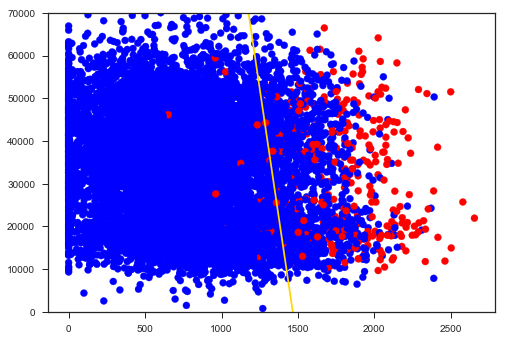

In [259]:
coef = lr.coef_
a = coef[0]
b = lr.intercept_
x = np.arange(0, 2600, 1)
y_plot = (b+a[0]*x)/-a[1]
plt.scatter(df['balance'],df['income'],c=colors)
plt.plot(x, y_plot, c = 'gold')
plt.ylim(0, 70000)
plt.show()

## 5) 
Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

In [252]:
X = df.loc[:,["balance", "income", "student"]]

In [260]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state = 9598) # Splitting the data into Test and Train

In [261]:
lr = LogisticRegression(class_weight='balanced', penalty = "l2").fit(X_train2, y_train2)
pred = lr.predict(X_test2)
print(roc_auc_score(y_test2, pred))

0.8753923908331784


**There is a slight improvement in prediction!**

## 6) 

Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

** Stratified K Fold is used with shuffle = True ** 

In [262]:
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 9598)

In [263]:
scores = cross_val_score(LogisticRegression(class_weight='balanced', penalty = "l2"), 
                                             X_train2, 
                                             y_train2, scoring='roc_auc', cv = cv ) 
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores))) 

Mean cross-validation accuracy: 0.95


#### Try with Scaled Data

In [264]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(class_weight="balanced", penalty = "l2"))
scores = cross_val_score(pipe, X_train2, y_train2, scoring='roc_auc', cv = cv)

print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores))) 

Mean cross-validation accuracy: 0.95


## 7) 
Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

#### Max_depth = 5

In [305]:
scores = cross_val_score(DecisionTreeClassifier(max_depth = 5, random_state = 9598, class_weight = "balanced"), 
                                             X_train2, y_train2, scoring='roc_auc', cv = cv ) 
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores))) 

Mean cross-validation accuracy: 0.90


**Accuracy on cross-validated set falls compared to logistic with L2 penalty.**

#### Plot the decision tree

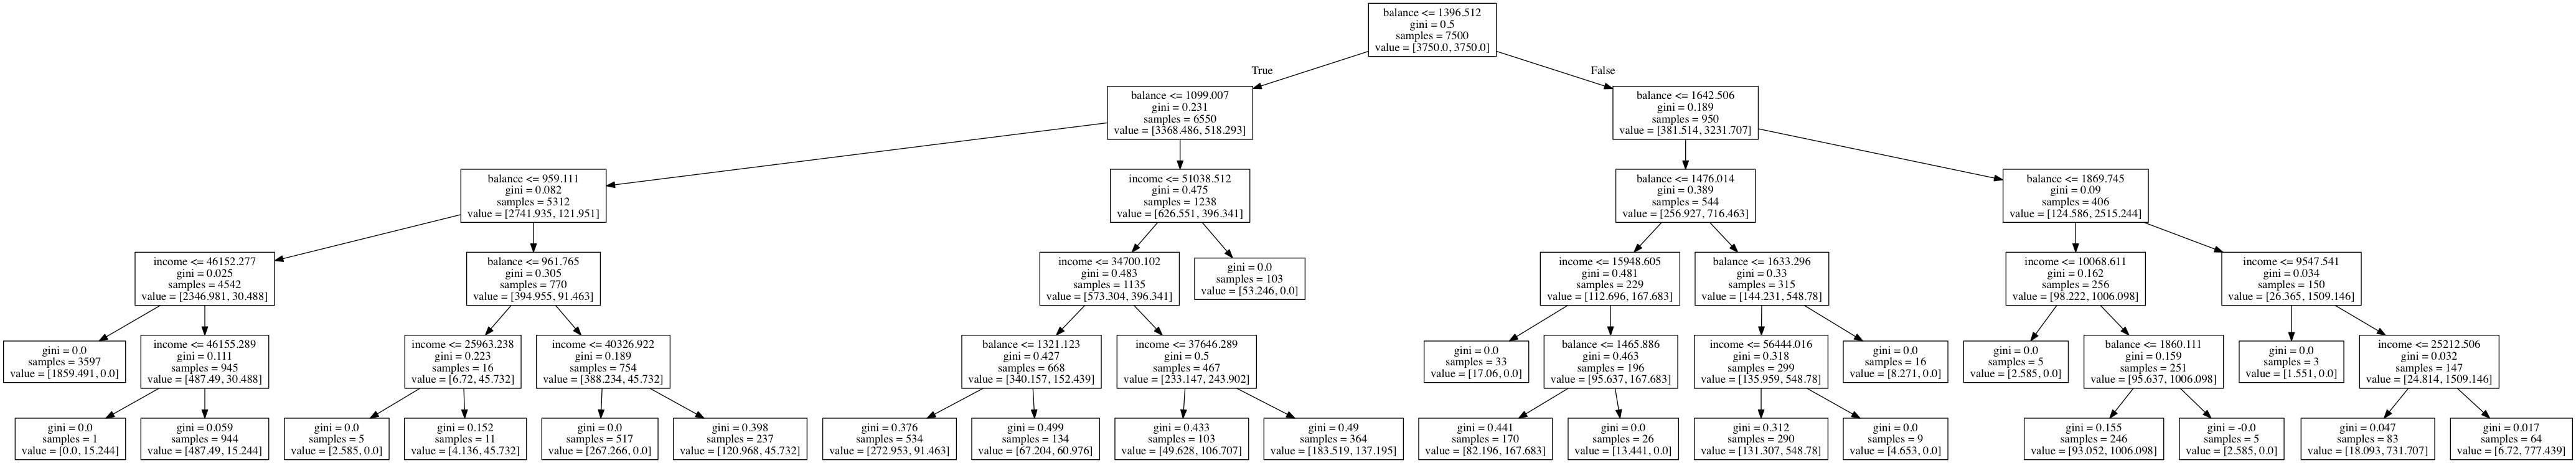

In [321]:
# get decision tree
dt = DecisionTreeClassifier(class_weight = "balanced", max_depth = 5).fit(X_train2, y_train2)

# plot decision tree
dot_data = StringIO()  
export_graphviz(dt, out_file=dot_data, feature_names=list(X_train2))  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## 8) 
Find the optimal decision tree depth and compute the AUC ROC. 

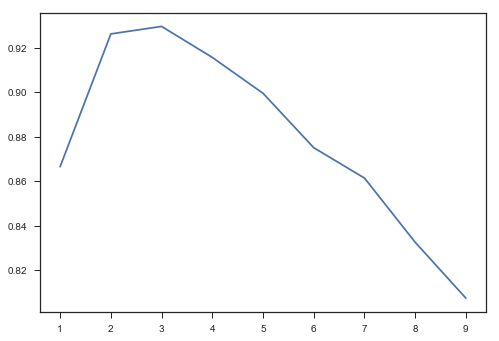

Optimal Decision Tree depth 2
Optimal Training Score 0.9296660349577278


In [319]:
depths = np.arange(1,10)
scores = []
for i in depths:
    dt = DecisionTreeClassifier(class_weight = "balanced", max_depth = i, random_state = 9598)
    scores.append(np.mean(cross_val_score(dt, X_train2, y_train2, scoring='roc_auc', cv = cv)))
plt.plot(depths, scores)
plt.show()
print("Optimal Decision Tree depth {}".format(np.argmax(scores)))
print("Optimal Training Score {}".format(np.max(scores)))

#### Best Model Parameters for Decision Tree Classifier on Test Set

In [318]:
dt = DecisionTreeClassifier(class_weight = "balanced", max_depth = 1, random_state = 9598).fit(X_train2, y_train2)
print("Accuracy on the test set: {:.3f}".format(dt.score(X_test2, y_test2)))

Accuracy on the test set: 0.891


# Part II: Recommendation Systems. 

In this problem we will use the notebook https://github.com/Columbia-Intro-Data-Science/APMAE4990-/blob/master/notebooks/matrix_factorization_recommender.ipynb  as
a starting point.

1) Split the ratings matrix `R_df` into training and testing sets. Remember we need to do this for rows and columns now. 


2) Evaluate the performance of the matrix factorization model for $K=50$. In particular, measure the:
 - Precision.
 - Recall. 

You can round up or down to the nearest integer for the ratings. 


3) Construct an item/item and user/user model, and evaluate the performance as in 2). How does it compare?

4) Check how your answer to 3) changes (if at all) as you try different values of K for K=10, 20, 100. 